### Import required libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from CartPole import CartPole
from ilqr.dynamics import constrain
from copy import deepcopy
from EstimateDynamics import local_estimate

### Formulate the iLQR problem

In [2]:
'''
1 - dt = time step
2 - N = Number of control points in the trajectory
3 - x0 = Initial state
4 - x_goal = Final state
5 - Q = State cost
6 - R = Control cost
7 - Q_terminal = Cost at the final step
8 - x_dynamics array stores the information regarding system. 
    x_dynamics[0] = m = mass of the pendulum bob 
    x_dynamics[1] = M = mass of the cart 
    x_dynamics[2] = L = length of the massless rod 
    x_dynamics[3] = g = gravity 
    x_dynamics[4] = d = damping in the system
'''
dt = 0.005
N = 600  # Number of time steps in trajectory.
x_dynamics = np.array([1, 5, 2, 9.80665, 1]) # m=1, M=5, L=2, g=9.80665, d=1
x0 = np.array([-3.0, 0.0, 0.1, 0.0])  # Initial state
x_goal = np.array([2.0, 0.0, 0.0, 0.0])
# Instantenous state cost.
Q = np.eye(5)
Q[2, 2] = 10
Q[3, 3] = 10
Q[4, 4] = 100
# Terminal state cost.
Q_terminal = 100 * np.eye(5)
# Instantaneous control cost.
R = np.array([[1.0]])

### iLQR on Cart Pole

In [3]:
cartpole_prob = CartPole(dt, N, x_dynamics, x0, x_goal, Q, R, Q_terminal)
xs, us = cartpole_prob.run_IterLinQuadReg()

iteration 0 accepted 305232.71465742035 [-1.60304796 -0.15936128 -1.24843188  1.63061614]
iteration 1 accepted 300303.6318199074 [-1.33210752 -0.02140117 -1.29115495  1.7029531 ]
iteration 2 accepted 295013.50103270594 [-1.10732322  0.09825543 -1.43357178  2.00219513]
iteration 3 accepted 286293.80371809454 [-0.79725869  0.37762753 -1.61756672  2.35189357]
iteration 4 accepted 266779.2460641228 [-0.48733429  0.90969111 -1.98541407  2.95793363]
iteration 5 accepted 185419.19997099612 [-0.35241988  2.1529778  -3.11480635  4.02623444]
iteration 6 accepted 82535.44885153562 [ 0.26391163  1.06911512 -1.81699514 -3.05576597]
iteration 7 accepted 24321.598902187583 [-0.68514415  0.67766832  0.57968475  1.14175305]
iteration 8 accepted 17664.597671026935 [-0.38587182  1.05923331 -0.00871309 -0.02328379]
iteration 9 accepted 17647.73614241439 [-0.40009085  1.0381707   0.01921391  0.0338444 ]
iteration 10 converged 17647.736142358415 [-0.40009098  1.03817049  0.01921548  0.03384748]


In [4]:
# State matrix split into individual states. For plotting and analysing purposes.
t = np.arange(N + 1) * dt
x = xs[:, 0] # Position
x_dot = xs[:, 1] # Velocity
theta = np.unwrap(cartpole_prob.deaugment_state(xs)[:, 2])  # Theta, makes for smoother plots.
theta_dot = xs[:, 3] # Angular velocity

### Simulate the real system and generate the data
Cost matrices, initial position and goal position will remain same as the above problem. As it indicates one policy. But still the initial positions and goal positions must be passed explicitly to the function. But you don't need to pass cost matrices (assume penalty on the system is same), this is just used to use to calculate the cost of the trajectory. Correct control action must be passed. Parameter gamma indicates how much of original data you want to keep

Variance of the Gaussian noise will be taken as input from a Unif(0, var_range) uniform distribution. Inputs: x_initial, x_goal, u, n_rollouts, pattern='Normal', pattern_rand=False, var_range=10, gamma=0.2, percent=20

Pattern controls how the control sequence will be modified after applying white Guassian noise (zero mean).
- Normal: based on the correction/mixing parameter gamma generate control (gamma controls how much noise we want).
- MissingValue: based on the given percentage, set those many values to zero (it is implicitly it uses "Normal" generated control is used). 
- Shuffle: shuffles the entire "Normal" generated control sequence.
- TimeDelay: takes the "Normal" generated control and shifts it by 1 index i.e. one unit time delay.
- Extreme: sets gamma as zeros and generates control based on only noise.

If 'pattern_rand' is 'True' then we don't need to send the explicitly, it will chose one randomly for every rollout (default is 'False'). If you want to chose specific pattern then send it explicitly. 

In [5]:
x_rollout, u_rollout, x_gmm, cost = cartpole_prob.gen_rollouts(x0, x_goal, us, n_rollouts=10, pattern_rand=True, 
                                                               var_range=10, gamma=0.2, percent=20)

### Local system dynamics/model estimate
loca_estimate: function takes the states (arranged in a special format, [x(t), u(t), x(t+1)]), no. of gaussian mixtures and no.of states.

In [6]:
model = local_estimate(x_gmm, components=5, NoOfstates=5)
A, B, C = model.estimate(N=N)

### iLQR on estimated model
Here system dynamics is specified in a special way. We give the A, B, C matrices as input. These matrices comes from GMM and GPS theory. They are the mean/expected trajectory followed by the states which is represented by the mean & covariance (A, B, C) matrices of a Gaussian. Remaining all properties of the iLQR problem remains the same (cost, initial & goal state, time steps). 

In [7]:
x_traj,u_traj = cartpole_prob.run_IterLinQuadReg_matrix(A, B, C)

iteration 0 accepted 325161.4803715129 [-1.8070363  -0.12380499 -0.95438123  1.82126156]
iteration 1 accepted 324018.70348892396 [-1.74309857 -0.08051638 -1.00744335  1.92752853]
iteration 2 accepted 323085.2641021594 [-1.68626108 -0.03368128 -1.05969288  2.02684713]
iteration 3 accepted 322192.39595237304 [-1.63494277  0.01703374 -1.11442222  2.12704366]
iteration 4 accepted 321202.68691189657 [-1.58569044  0.07531908 -1.17603004  2.23581988]
iteration 5 accepted 319927.88253202924 [-1.53597957  0.14694521 -1.25106371  2.3632785 ]
iteration 6 accepted 317988.5325113506 [-1.48403649  0.24209468 -1.35139822  2.52600163]
iteration 7 accepted 314376.1018007247 [-1.43031378  0.38073767 -1.50295961  2.7564032 ]
iteration 8 accepted 305507.97008598864 [-1.38668109  0.60419917 -1.77707027  3.12765369]
iteration 9 accepted 272050.19517888746 [-1.43998469  0.94454701 -2.45616095  3.77916606]
iteration 10 accepted 107018.40632742574 [-2.08306678 -0.27056741  1.0657891   2.02038232]
iteration 11 

### Plot

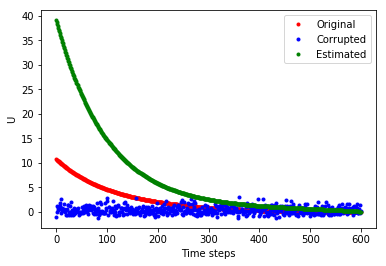

In [8]:
# Control sequence
plt.plot(np.arange(us.shape[0]), us, 'r.', label='Original')
plt.plot(np.arange(us.shape[0]), u_rollout[0:N], 'b.', label='Corrupted')
plt.plot(np.arange(us.shape[0]), u_traj, 'g.', label='Estimated')
plt.xlabel('Time steps')
plt.ylabel('U')
plt.legend()
plt.show()

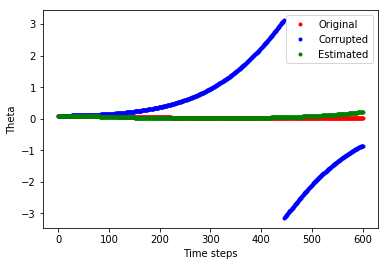

In [9]:
plt.plot(np.arange(xs.shape[0]), xs[:, 2], 'r.', label='Original')
plt.plot(np.arange(xs.shape[0]), cartpole_prob.deaugment_state(x_rollout)[0:N+1, 2], 'b.', label='Corrupted')
plt.plot(np.arange(xs.shape[0]), cartpole_prob.deaugment_state(x_traj)[:, 2], 'g.', label='Estimated')
plt.xlabel('Time steps')
plt.ylabel('Theta')
plt.legend()
plt.show()

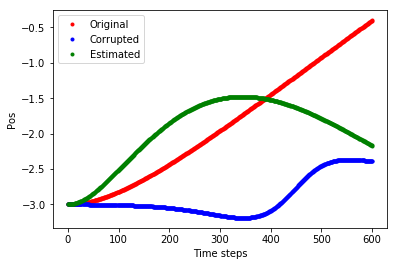

In [10]:
plt.plot(np.arange(xs.shape[0]), xs[:, 0], 'r.', label='Original')
plt.plot(np.arange(xs.shape[0]), cartpole_prob.deaugment_state(x_rollout)[0:N+1, 0], 'b.', label='Corrupted')
plt.plot(np.arange(xs.shape[0]), cartpole_prob.deaugment_state(x_traj)[:, 0], 'g.', label='Estimated')
plt.xlabel('Time steps')
plt.ylabel('Pos')
plt.legend()
plt.show()